In [10]:
import sys
import os
sys.path.append("..")

import jax
jax.config.update("jax_enable_x64", True)
import equinox as eqx
import jax.numpy as jnp
from jax import vmap
import jax_dataloader as jdl
import networks
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard
import argparse
from optax.contrib import reduce_on_plateau

problem = "advection"
network = "modified_deeponet"
running_on = "local"
num_epochs = 10
load_operator = True
use_hino = True

In [11]:
if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    hparams_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/hyperparameters/"
    checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"
elif running_on == "idun":
    data_path = "/cluster/work/eirikaf/data/"
    hparams_path = "/cluster/home/eirikaf/phlearn-summer24/eirik_prosjektoppgave/hyperparameters/"
    checkpoint_path = "/cluster/work/eirikaf/checkpoints/"
else:
    raise ValueError("Invalid running_on")

scaled_data = jnp.load(data_path + problem + "_z_score.npz")
a_train_s = jnp.array(scaled_data["a_train_s"])
u_train_s = jnp.array(scaled_data["u_train_s"])
a_val_s = jnp.array(scaled_data["a_val_s"])
u_val_s = jnp.array(scaled_data["u_val_s"])

x_train_s = jnp.array(scaled_data["x_train_s"])
t_train_s = jnp.array(scaled_data["t_train_s"])

z_score_data = {'u_std' : scaled_data["u_std"],
                'x_std' : scaled_data["x_std"],
                't_std' : scaled_data["t_std"],}
# DATALOADERS
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_s, u_train_s, asnumpy = False), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_s, u_val_s, asnumpy = False), batch_size=16, shuffle=True, backend='jax', drop_last=True)

# AUTOPARALLELISM
sharding_a, sharding_u, replicated = create_device_mesh()

# IMPORT WANTED NETWORK ARCHITECTURE
if network == "deeponet":
    from networks.deeponet import DeepONet as OperatorNet
    from networks.deeponet import Hparams as OperatorHparams
    if use_hino:
        from networks.hino_DON import *
        from networks.hino_DON import HINO_DON as HamiltonianNet
    else:
        from networks.hno_DON import *
        from networks.hno_DON import HNO_DON as HamiltonianNet
elif network == "modified_deeponet":
    from networks.modified_deeponet import ModifiedDeepONet as OperatorNet
    from networks.modified_deeponet import Hparams as OperatorHparams
    if use_hino:
        from networks.hino_DON import *
        from networks.hino_DON import HINO_DON as HamiltonianNet
    else:
        from networks.hno_DON import *
        from networks.hno_DON import HNO_DON as HamiltonianNet
elif network == "fno1d":
    if use_hino:
        from networks.hino_DON import *
        from networks.hino_DON import HINO_DON as HamiltonianNet
    else:
        from not_in_use.hno_DON import *
elif network == "fno2d":
    if use_hino:
        from networks.hino_DON import *
        from networks.hino_DON import HINO_DON as HamiltonianNet
    else:
        from not_in_use.hno_DON import *
elif network == "fno_timestepping":
    if use_hino:
        from networks.hino_DON import *
        from networks.hino_DON import HINO_DON as HamiltonianNet
    else:
        from not_in_use.hno_DON import *
else:
    raise ValueError("Invalid network")

if load_operator:
    operator_trainer = Trainer.from_checkpoint(checkpoint_path+f"{network}_{problem}", 
                                            OperatorNet, 
                                            Hparams=OperatorHparams,
                                            replicated=replicated,)

    operator_net = operator_trainer.model
    operator_net_hparams = operator_trainer.hparams
else:
    with open(hparams_path +f"{network}_{problem}.json", "rb") as f:
        hparams_operator_net_dict = json.load(f)
        operator_net_hparams = OperatorHparams(**hparams_operator_net_dict)
    operator_net = OperatorNet(operator_net_hparams)

if use_hino:
    Trainer.compute_loss = staticmethod(compute_loss_hino)
    Trainer.evaluate = eqx.filter_jit(staticmethod(evaluate_hino), donate="all-except-first")
else:
    Trainer.compute_loss = staticmethod(compute_loss_hno)
    Trainer.evaluate = eqx.filter_jit(staticmethod(evaluate_hno), donate="all-except-first")

# IMPORT HYPERPARAMETERS
with open(hparams_path + "energy_net_" + problem + '.json', "rb") as f:
    hparams_energy_net_dict = json.load(f)
    energy_net_hparams = EnergyNetHparams(**hparams_energy_net_dict)
    
energy_net = EnergyNet(energy_net_hparams)

model = HamiltonianNet(energy_net = energy_net, operator_net= operator_net)
if replicated:
    model = eqx.filter_shard(model, replicated)

hparams = Hparams(energy_net=energy_net_hparams, operator_net=operator_net_hparams)

# INITIALIZE OPTIMIZERS
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:

if network in ["fno1d", "fno2d", "fno_timestepping"]:
    θ_optimizer = optax.chain(
        conjugate_grads_transform(), # we have to conjugate the gradients for the FNO networks
        optax.adam(operator_net_hparams.learning_rate),
        reduce_on_plateau(
            patience=PATIENCE,
            cooldown=COOLDOWN,
            factor=FACTOR,
            rtol=RTOL,
            accumulation_size=ACCUMULATION_SIZE,
        ),
    )
else:
    θ_optimizer = optax.chain(
        optax.adam(operator_net_hparams.learning_rate),
        reduce_on_plateau(
            patience=PATIENCE,
            cooldown=COOLDOWN,
            factor=FACTOR,
            rtol=RTOL,
            accumulation_size=ACCUMULATION_SIZE,
        ),
    )
    
θ_optimizer = optax.adam(0.0)
    
φ_optimizer = optax.chain(
    optax.adam(energy_net_hparams.learning_rate),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)

if operator_net.is_self_adaptive: # Self-adaptive weights are enabled 
    λ_u_optimizer = optax.chain(optax.adam(0.), optax.scale(-1.))
    #λ_F_optimizer = optax.chain(optax.adam(energy_net_hparams.λ_learning_rate), optax.scale(-1.))
    opt = optax.multi_transform({'θ': θ_optimizer, 'φ': φ_optimizer, 'λ_u': λ_u_optimizer}, param_labels=param_labels_hno_self_adaptive)
else:
    opt = optax.multi_transform({'θ': θ_optimizer, 'φ': φ_optimizer}, param_labels=param_labels_hno)
    
opt_state = opt.init(eqx.filter([model], eqx.is_array))

trainer = Trainer(model, 
                opt, 
                opt_state, 
                train_loader, 
                val_loader, 
                hparams = hparams, 
                save_path = checkpoint_path, 
                save_path_prefix = network + "_" + problem + "_" + ("HINO" if use_hino else "HNO") + "_", 
                sharding_a = sharding_a, 
                sharding_u = sharding_u,
                x = x_train_s,
                t = t_train_s,
                replicated = replicated)

KeyError: 'eps is not a file in the archive'

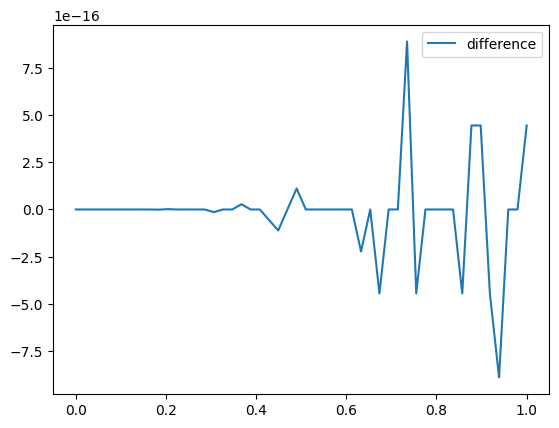

In [3]:
def u(x):
    return jnp.cos(x**2)

def u_x(x):
    return -2*x*jnp.sin(x**2)

def u_xx(x):
    return -2*(jnp.sin(x**2) + x*jnp.cos(x**2)*2*x)

def F(u_val, u_x_val):
    return jnp.cos(u_val*u_x_val)

def dF_du(x):
    return -jnp.sin(u(x)*u_x(x))*u_x(x)

def dF_du(u_val, u_x_val):
    return -jnp.sin(u_val*u_x_val)*u_x_val

def dF_du_x(u_val, u_x_val):
    return -jnp.sin(u_val*u_x_val)*u_val
    
def d2F_du_dx(x):
    return -(u_x(x)*jnp.cos(u(x)*u_x(x))*(u_x(x)**2+u(x)*u_xx(x)) + jnp.sin(u(x)*u_x(x))*u_xx(x))

def d2F_du_dx2(x):
    return grad(lambda x: -jnp.cos(u(x)*u_x(x))*u_x(x)**2)(x) + grad(lambda x: -jnp.sin(u(x)*u_x(x))*u_xx(x))(x)


x = jnp.linspace(0, 1)
dF_du_autodiff = lambda x : grad(F, 0)(u(x), u_x(x))
d2F_du_dx_autodiff = lambda x : grad(dF_du_autodiff)(x)

dF_du_du = lambda x : grad(dF_du)(u(x), u_x(x))
dF_du_du_x = lambda x : grad(dF_du, 1)(u(x), u_x(x))
d2F_du_dx_autodiff2 =  lambda x : dF_du_du(x)*u_x(x) + dF_du_du_x(x)*u_xx(x)

d2F_du_dx_autodiff_grid = vmap(d2F_du_dx_autodiff)(x)
d2F_du_dx_autodiff_grid2 = vmap(d2F_du_dx_autodiff2)(x)




import matplotlib.pyplot as plt
plt.figure()
plt.plot(x, d2F_du_dx_autodiff_grid2-d2F_du_dx(x), label="difference")
plt.legend()
plt.show()

In [4]:
import matplotlib.pyplot as plt

In [5]:
𝒢δℋ, u_t = trainer.model.predict_whole_grid(a_train_s[0], x_train_s, t_train_s)

In [6]:
import matplotlib.pyplot as plt

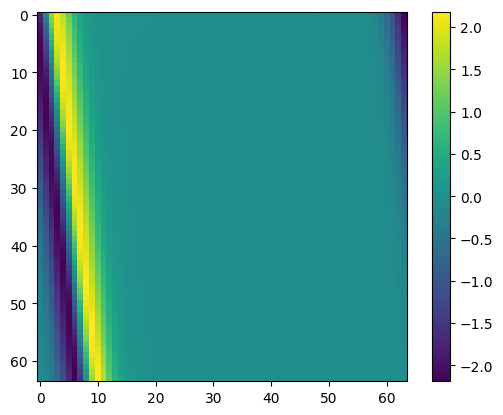

In [7]:
plt.imshow(u_t)
plt.colorbar()

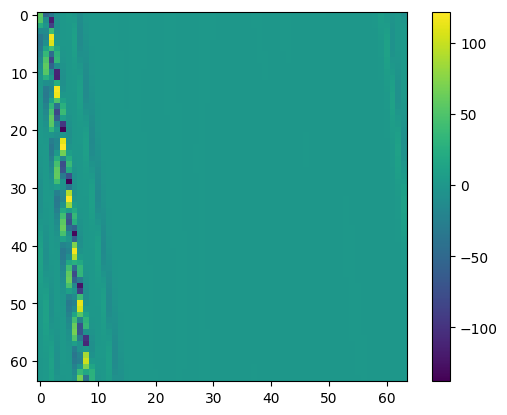

In [8]:
plt.imshow(𝒢δℋ)
plt.colorbar()

In [9]:
u = model.u.predict_whole_grid(a_train_s[0], x_train_s, t_train_s)

In [10]:
from traditional_solvers import Dx

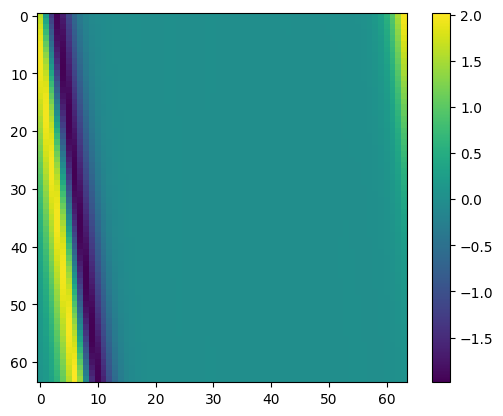

In [11]:
plt.imshow(Dx(model.u.decode_u(u), model.u.decode_x(x_train_s)[1], axis=1))
plt.colorbar()

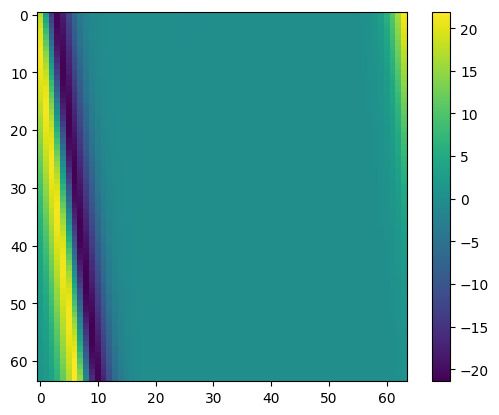

In [12]:
xx, tt = jnp.meshgrid(x_train_s, t_train_s)
plt.imshow(vmap(model.u.Dx, (None, 0, 0))(a_train_s[0], xx.ravel(), tt.ravel()).reshape(xx.shape))
plt.colorbar()

In [12]:
def pred1(a, x, t):
    u = lambda x : model.u(a, x, t) # u(x), function in x only (for convenience)
    u_x = grad(u) # u_x(x), function

    dFdu = lambda x : grad(model.F, 0)(u(x), u_x(x)) # ∂F/∂u(x), function
    dFdu_x = lambda x : grad(model.F, 1)(u(x), u_x(x)) # ∂F/∂u_x(x), function
    δℋ = lambda x : dFdu(x) - grad(dFdu_x)(x) # δℋ/δu(x), function
    
    𝒢δℋ = grad(δℋ)
    return -𝒢δℋ(x)

def pred2(a, x, t):
    u = lambda x : model.u(a, x, t) # u(x), function in x only (for convenience)
    u_x = grad(u) # u_x(x), function
    u_xx = grad(u_x) # u_xx(x), function
    u_xxx = grad(u_xx) # u_xxx(x), function
    dF__du = grad(model.F)
    dF__du_x = grad(model.F, 1)
    d2F__du2 = grad(dF__du)
    d2F__du_x2 = grad(dF__du_x, 1)
    d2F__du_du_x = grad(dF__du,1)
    d3F__du_x_du2 = grad(d2F__du2, 1)
    d3F__du_x2_du = grad(d2F__du_x2)
    d3F__du_x3 = grad(d2F__du_x2, 1)
    d2F__du_dx = d2F__du2(u(x), u_x(x)) * u_x(x)  + d2F__du_du_x(u(x), u_x(x)) * u_xx(x)
    
    d3F__du_x_dx2 = d2F__du_du_x(u(x), u_x(x))*u_xx(x) +\
                                d2F__du_x2(u(x), u_x(x))*u_xxx(x) +\
                                d3F__du_x_du2(u(x), u_x(x))*u_x(x)**2 +\
                                2*d3F__du_x2_du(u(x), u_x(x))*u_x(x)*u_xx(x)+\
                                u_xx(x)**2*d3F__du_x3(u(x), u_x(x))
                                 
    𝒢_δℋ__δu = - d2F__du_dx +  d3F__du_x_dx2
    return 𝒢_δℋ__δu
    
def multiple_query_points_one_a(func, a, x, t):
    return vmap(func, (None, 0, 0))(a, x, t)

def predict_whole_grid(func, a, x, t):
    """When we want to predict on the whole grid, we simply use the operator network's output, without the energy net.

    Args:
        a (M+1,): input function
        x (M+1,): spatial grid
        t (N+1,): temporal grid

    Returns:
        u_pred (N+1, M+1): prediction at the given grid points.
    """
    xx, tt = jnp.meshgrid(x, t)
    𝒢δℋ = multiple_query_points_one_a(func, a, xx.ravel(), tt.ravel())
    
    return 𝒢δℋ.reshape(xx.shape)

In [13]:
pred1(a_train_s[0], x_train_s[10], t_train_s[4])

NameError: name 'grad' is not defined

In [ ]:
pred1(a_train_s[0], x_train_s[10], t_train_s[4])

In [134]:
def sech(x):
    return 1/jnp.cosh(x)

def u_soliton(x, t, key = random.key(0), P=20):    
    #key_cs, key_ds = random.split(key, 2)
    #c = random.uniform(key_cs, minval=0.5, maxval=1.5, shape=())
    #d = random.uniform(key_ds, minval=0, maxval=1, shape=())
    c = 1.2
    d = 0.3
    
    return 2 * c**2 * sech(c * ((x-c*t+P/2-P*d) % P - P/2))**2

data = jnp.load(data_path + problem + ".npz")

u_standardizer = MinMaxStandardizer(data["data"])

x_fine = jnp.linspace(0,20,1000, endpoint=False)
t_fine = jnp.linspace(0,2,1000, endpoint=False)

x_fine_s = x_fine / 20 
t_fine_s = t_fine / 2
u_s = vmap(u_soliton, (None, 0))(x_fine, t_fine)
u_s = u_standardizer.encode(u_s)

In [139]:
x_fine = jnp.linspace(0,20,100, endpoint=False)

x_standardizer = GaussianStandardizer(x_fine)
x_fine_s = x_standardizer.encode(x_fine)

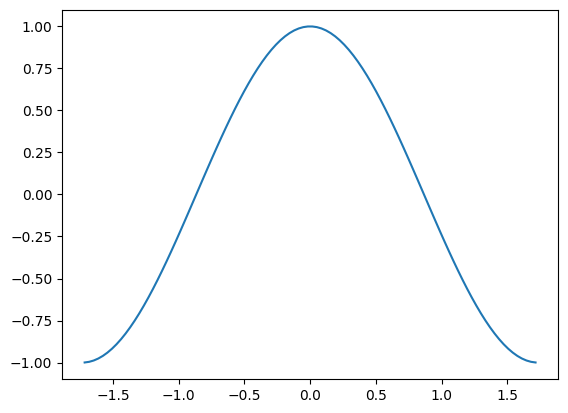

In [142]:
plt.plot(x_fine_s, jnp.cos(2*jnp.pi*x_fine_s/(20/x_standardizer.std)))

In [135]:
from traditional_solvers import Dx

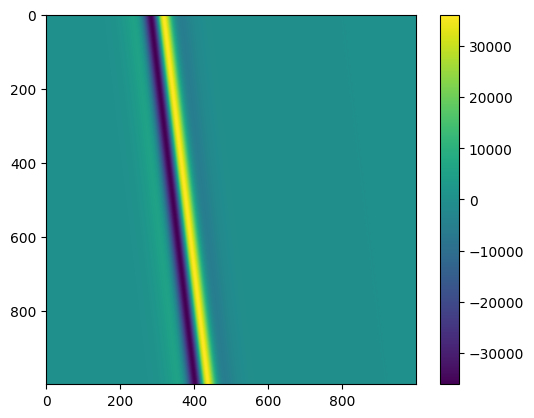

In [136]:
plt.imshow(Dx(Dx(Dx(u_s, x_fine_s[1], axis=-1), x_fine_s[1], axis=-1), x_fine_s[1], axis=-1))
plt.colorbar()

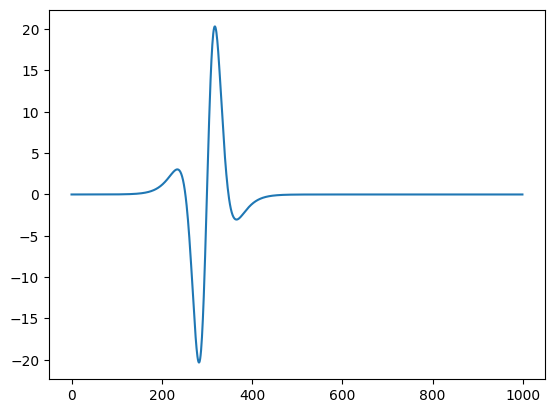

In [123]:
plt.plot(vmap(u_xxx, (0, None))(jnp.linspace(0, 20, 1000, endpoint=False),0))

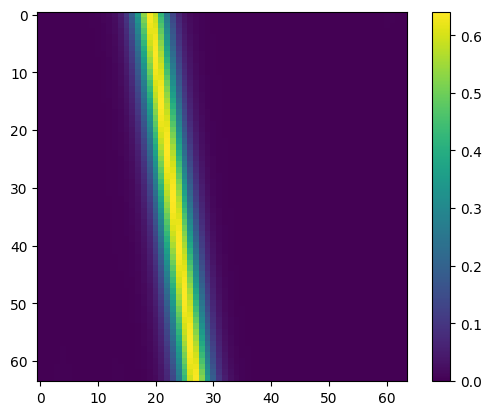

In [82]:
plt.imshow(model.u.predict_whole_grid(a_s, x_train_s, t_train_s))
plt.colorbar()

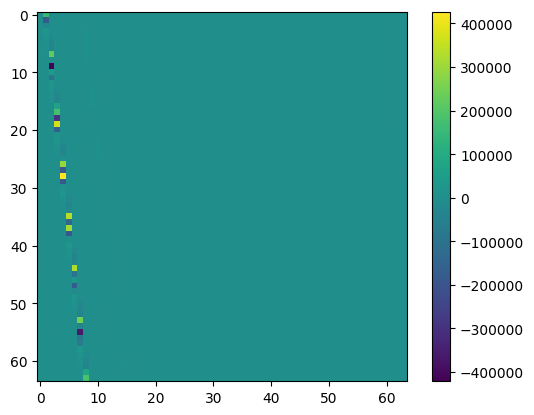

In [83]:
plt.imshow(predict_whole_grid(pred1, a_train_s[0], x_train_s, t_train_s))
plt.colorbar()

In [60]:
pred1(a_train_s[0], x_train_s[10], t_train_s[4])

Array(-208.50818333, dtype=float64)

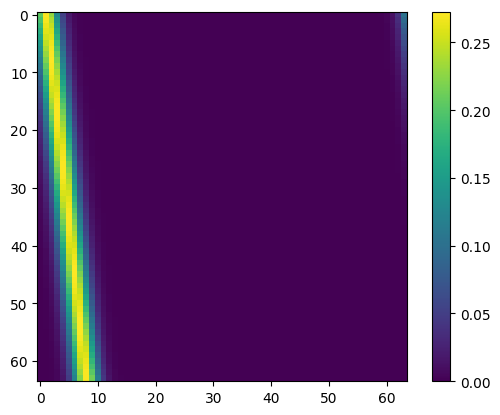

In [7]:
plt.imshow(model.u.predict_whole_grid(a_train_s[0], x_train_s, t_train_s)**2)
plt.colorbar()

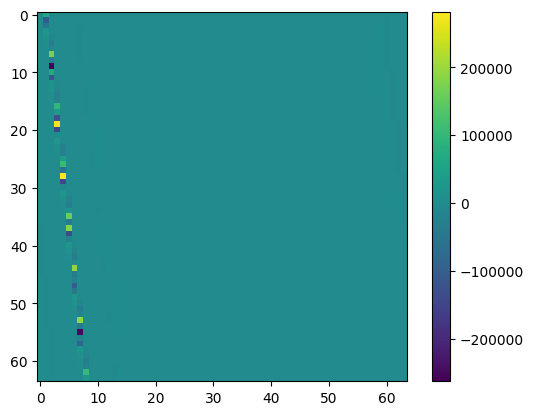

In [10]:
plt.imshow(𝒢δℋ)
plt.colorbar() 

In [8]:
from traditional_solvers import Dx
import matplotlib.pyplot as plt

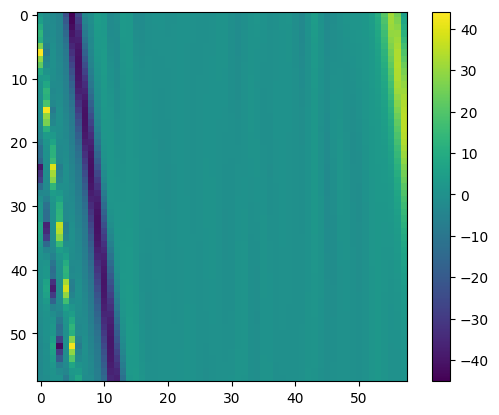

In [12]:
plt.imshow(Dx(dF_du, x_train_s[1], axis=1)[3:-3, 3:-3])
plt.colorbar()

In [28]:
dF_du, ddF_du_dx = predict_whole_grid(a_train_s[0], x_train_s, t_train_s)

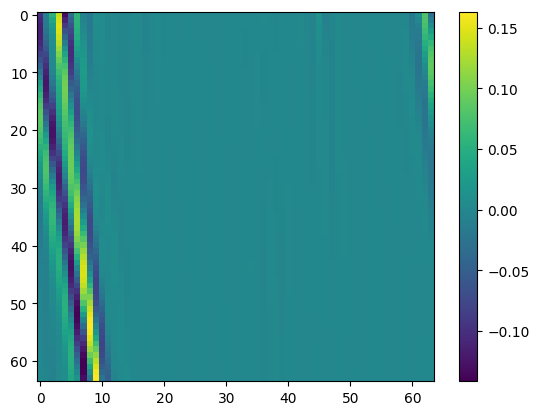

In [29]:

plt.imshow(Dx(dF_du, x_train_s[1], axis=1)-ddF_du_dx, aspect='auto')
plt.colorbar()

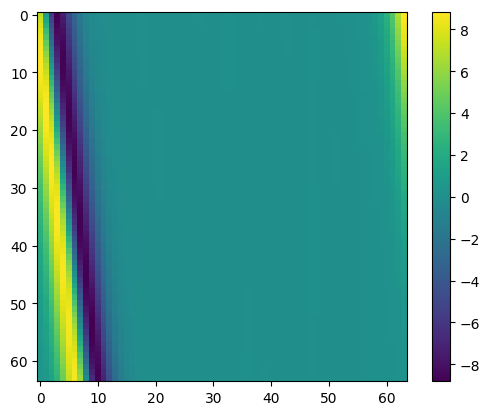

In [24]:
plt.imshow(Dx(u_eval, x_train_s[1], axis=1))
plt.colorbar()

In [8]:
jnp.mean(𝒢δℋ)

Array(-799.8866447, dtype=float64)

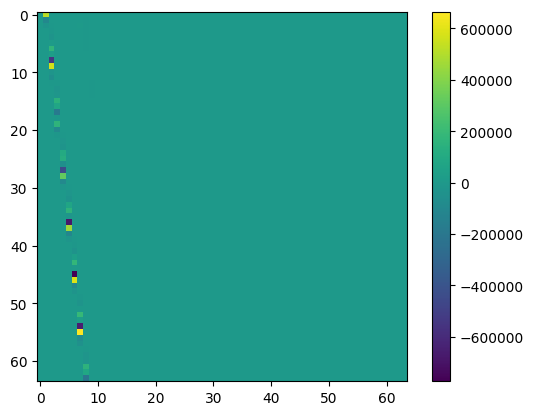

In [7]:
plt.imshow(𝒢δℋ)
plt.colorbar()

In [22]:
from traditional_solvers import Dx
u_eval = model.u.predict_whole_grid(a_train_s[0], x_train_s, t_train_s)

In [9]:
jnp.mean(u_train_s)

Array(3.80003463e-12, dtype=float64)

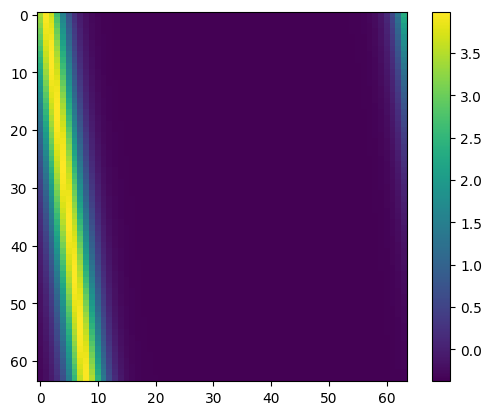

In [8]:
plt.imshow(u_eval)
plt.colorbar()

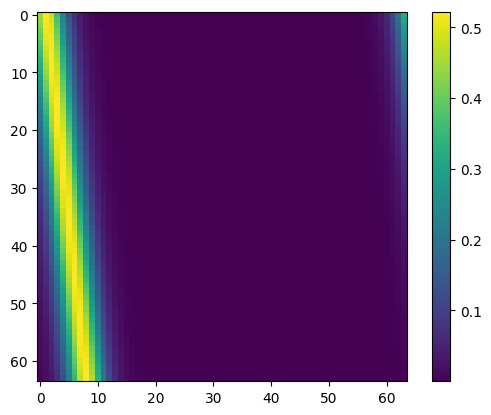

In [14]:
u_standardizer2 = MinMaxStandardizer(u_train_s)
u_train_s2 = u_standardizer2.encode(u_train_s)

plt.imshow(u_train_s2[0])
plt.colorbar()

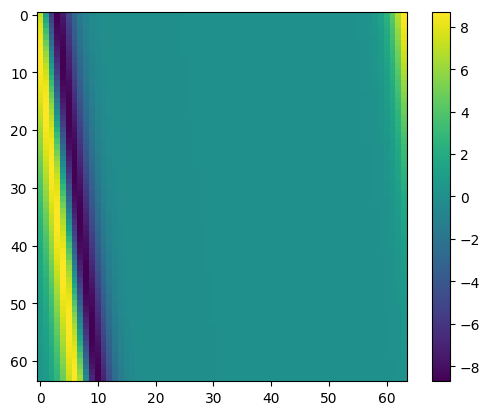

In [15]:
u_x = Dx(u_train_s2[0], x_train_s[1], axis=1)
plt.imshow(u_x)
plt.colorbar()

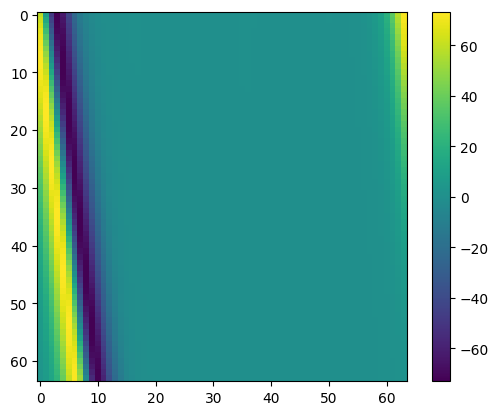

In [9]:
u_x = vmap(vmap(grad(model.u,1), (None, 0, None)), (None, None, 0))(a_train_s[0], x_train_s, t_train_s)
plt.imshow(u_x)
plt.colorbar()

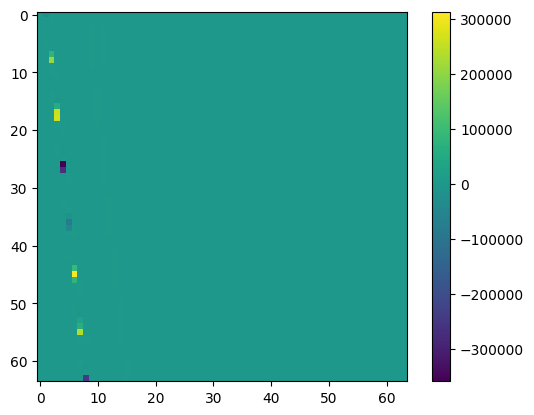

In [5]:
plt.imshow(𝒢δℋ)
plt.colorbar()

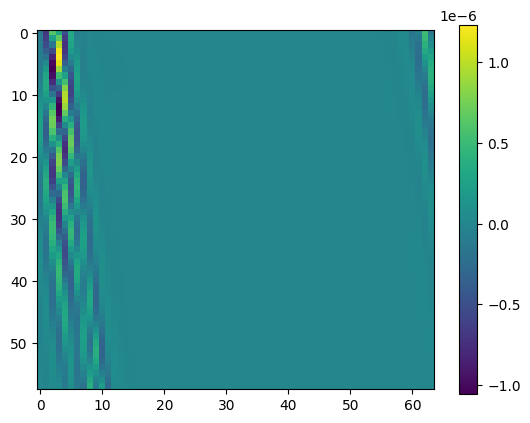

In [6]:
plt.imshow(u_t[3:-3]- Dx(u_eval, t_train_s[1])[3:-3])
plt.colorbar()

In [27]:
sampled_points = random.choice(random.key(0), 𝒢δℋ.flatten(), (1000,), replace=False)
print(jnp.max(sampled_points), jnp.min(sampled_points))

8015684.048607282 -18216071.276172172


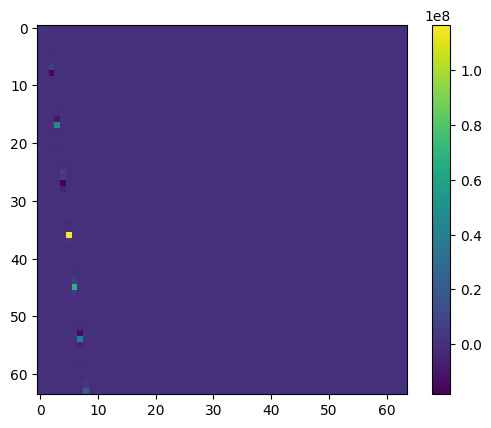

In [26]:
plt.imshow(𝒢δℋ)
plt.colorbar()

In [11]:
a = a_train_s[0]
x = x_train_s[0]
t = t_train_s[0]
u_eval, u_t = value_and_grad(operator_net, 2)(a,x,t) # u and u_t, values

u = lambda x : operator_net(a, x, t) # u(x), function in x only (for convenience)
u_x = grad(u) # u_x(x), function


dFdu = lambda x : grad(energy_net, 0)(u(x), u_x(x)) # ∂F/∂u(x), function
dFdu_x = lambda x : grad(energy_net, 1)(u(x), u_x(x)) # ∂F/∂u_x(x), function
δℋ = lambda x : dFdu(x) - grad(dFdu_x)(x) # δℋ/δu(x), function

𝒢δℋ =  -grad(δℋ)(x) # 𝒢 δℋ/δu , value

In [15]:
energy_net(u(x), u_x(x)) # F(u(x), u_x(x)), value

Array(63.77381896, dtype=float64)

In [14]:
dFdu_x(x)

Array(1.07151547, dtype=float64)